(labs:cor6)=
# Deconvolution

<hr>

## 📌 Commentaires pour les intervenants

- L'année dernière, les étudiants n'ont abordé que le débruitage.
  Le déconvolution ne sera donc abordée que par les étudiants les plus rapides.
  Ce n'est pas grave, d'autant plus que l'exercice sur la déconvolution est similaire à celui sur le débruitage.
- il me semble important que les étudiants sachent simuler une observation, c'est-à-dire générer le modèle direct.
  En effet, c'est une manière classique de produire des données et la solution recherchée.
  C'est pour cela que les premières questions, loin d'être anodines, leur demande de générer une image bruitée ou floutée.
- La correction que je propose ci-dessous est très complète : je n'attends pas autant des étudiants.
- Il faut continuer à pousser les étudiants à développer leur esprit critique.
  Cela commence par faire une bonne observation des résultats obtenus, à faire une interprétation correcte,
  à proposer des solutions pour améliorer la méthode où pour aller plus loin dans la compréhension du problème,
  et enfin à proposer de nouvelles expériences pour vérifier les hypothèses émises.
  
<hr>

The objectives of this exercise are:
* know how to apply a specific degradation to an image
* understand why naive deconvolution does not work
* implement a Wiener filter

In [10]:
# Ne pas utiliser scipy.ndimage.convolve (qui ne permet pas de faire de convolution circulante)
from scipy.ndimage.filters import convolve

from numpy import sqrt, ones, zeros, absolute, log, real, arange, argmin
from numpy.linalg import norm
from numpy.fft import fft2, ifft2, fftshift

from skimage.io import imread
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.restoration import wiener
from skimage.metrics import mean_squared_error

from matplotlib.pyplot import imshow, show, title, figure, subplot, plot, xlabel, ylabel

## Original and noisy images

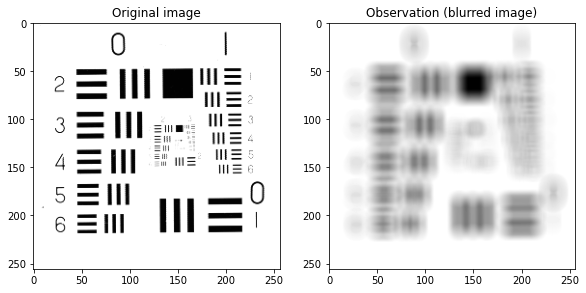

In [11]:
# TODO : montrer sur un Dirac ?
# x = zeros((49,49))
# x[24,24] = 1

# Image originale x
x = imread("../_static/src/5.1.13.tiff")
x = x.astype(float) # Attention : convertir en float !

# Image floutée w
L = 10
h = disk(L)
y = convolve(x, h, mode="wrap")

# Affichage
figure(figsize=(15,10))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Original image")
subplot(1,3,2)
imshow(y, cmap="gray")
title("Observation (blurred image)");

The "USAF 1951" resolution chart is a tool for measuring the resolution of optical instruments.
It was designed by the U.S. Air Force.
Its interest in image processing is to measure the resolution capacity of methods.
Here, it is interesting because once blurred, it is difficult to count the lines and read the figures.

## Inverse filter on the non-noisy image

In [12]:
# Notez qu'il n'est pas nécessaire ici d'utiliser fftshift.
Y = fft2(y)
H = fft2(h, Y.shape)     # Attention, pour pouvoir diviser les deux FFT, elles doivent être de la même taille !
Xest = Y/H
xest = real(ifft2(Xest)) # Attention, bien prendre la partie réelle !

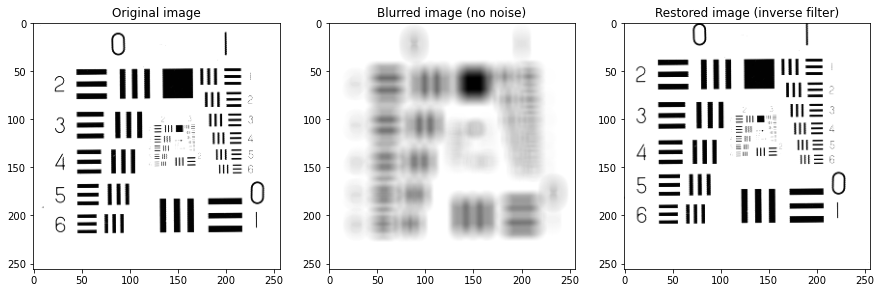

In [13]:
# Affichage
figure(figsize=(15,10))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Original image")
subplot(1,3,2)
imshow(y, cmap="gray")
title("Blurred image (no noise)")
subplot(1,3,3)
imshow(xest, cmap="gray")
title("Restored image (inverse filter)")
show()

In the absence of noise, the inverse filter works perfectly (except for a translation, due to the PSF size).

## Inverse filter with noise

In [14]:
# Calcul de la variance d'un bruit blanc gaussien pour un RSB donné
def variance(snr, x):
    M, N = x.shape
    return norm(x)**2 / (M*N) * 10**(-snr/10)

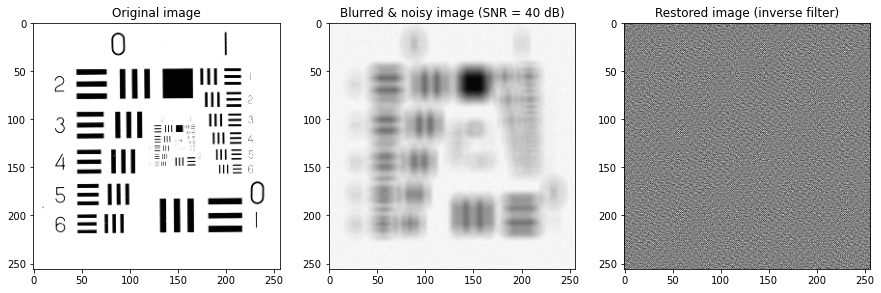

In [15]:
# Image floutée + bruitée y
rsb = 40
var = variance(rsb, y)
y = random_noise(y, mode='gaussian', clip=False, var=var)

# Filtrage inverse
Y = fft2(y)
H = fft2(h, Y.shape)
Xest = Y/H
xest = real(ifft2(Xest))

# Affichage
figure(figsize=(15,10))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Original image")
subplot(1,3,2)
imshow(y, cmap="gray")
title(f"Blurred & noisy image (SNR = {rsb} dB)")
subplot(1,3,3)
imshow(xest, cmap="gray")
title("Restored image (inverse filter)")
show()

On the contrary, when the image is noisy (even slightly: here SNR equals 40 dB), the restoration is not at all acceptable!

## Wiener filter with noise

Be careful, there is another `wiener` function (`skimage.filters.wiener`), but it is more tricky.
Instead, use `skimage.restoration.wiener`, not forgetting to add `clip=False`.

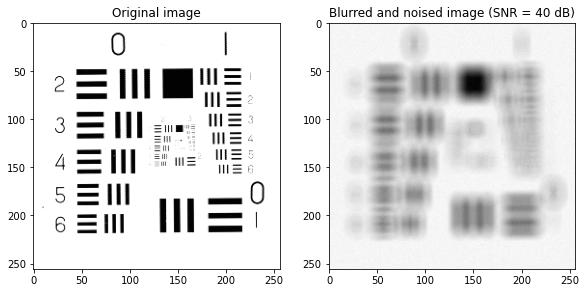

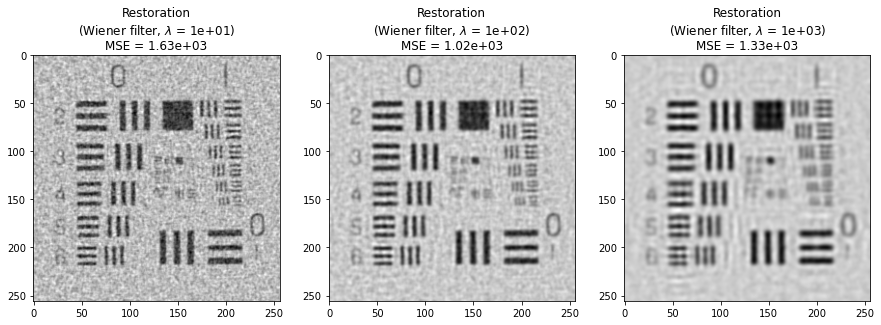

In [16]:
# Affichage
figure(figsize=(15,10))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Original image")
subplot(1,3,2)
imshow(y, cmap="gray")
title(f"Blurred and noised image (SNR = {rsb} dB)")
show()

figure(figsize=(15,10))
lbds = [1e1, 1e2, 1e3]
for i, lbd in enumerate(lbds):
    xest = wiener(y, h, lbd, clip=False) # Attention : clip = False
    eqm = mean_squared_error(x, xest)
    subplot(1,3,1+i)
    imshow(xest, cmap="gray")
    title(f"Restoration\n(Wiener filter, $\lambda$ = {lbd:.0e})\nMSE = {eqm:.2e}")

These first results have been obtained for three values of $\lambda$.
They show that in terms of MSE, there is a compromise to be made between denoising and deconvolution.
If $\lambda$ is too low, the restored image is deconvolved but remains very noisy;
if $\lambda$ is too large then the image remains blurry.

For a better analysis, we represent the MSE with respect to $\lambda$.

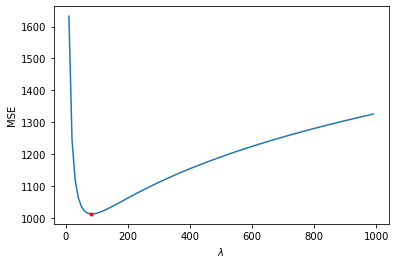

The best restoration is obtained for lambda = 80 and gives MSE = 1327.96.


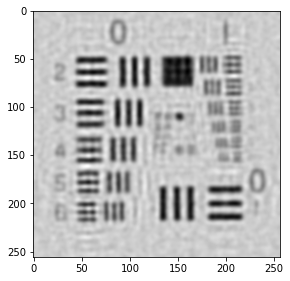

In [17]:
lbds = arange(1e1, 1e3, 1e1)
mses = zeros(lbds.shape)
for i, lbd in enumerate(lbds):
    xest = wiener(y, h, lbd, reg=None, is_real=True, clip=False)
    mses[i] = mean_squared_error(x, xest)

# Meilleure restauration
i = argmin(mses)
mse = mses[i]
lbd = lbds[i]

# Évolution de l'EQM
plot(lbds,mses)
plot(lbd,mse, '.r')
xlabel("$\lambda$")
ylabel("MSE")
show()

print(f"The best restoration is obtained for lambda = {lbd:.0f} and gives MSE = {eqm:.2f}.")

figure(figsize=(15,10))
subplot(2,3,1)
imshow(xest, cmap="gray");

I find personally that this value of $\lambda$ gives a less clear picture than for lower values of $\lambda$ (as presented above).
This shows that the MSE does not perfectly represent the perceived quality.
But the perceived quality is subjective and depend on the desired objective, whereas MSE is an objective measure.

Finally, as for denoising methods, it is very difficult to set a priori the value of the parameter $\lambda$.